# 02 - Data Preparation and Splitting

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/02_data_preparation.ipynb)

**Project**: Detection of Anomalies with Localization  
**Dataset**: MVTec AD (Hazelnut, Carpet, Zipper)  
**Phase**: Data Preparation - Clean Domain Split

---

## Objectives

1. Implement train/val/test split for clean domain
2. Create reproducible splits with seed=42
3. Verify split integrity and statistics
4. Visualize samples from each split
5. Test Dataset class with transforms
6. Save splits to JSON for future use

## Setup - Mount Drive & Configure Paths

In [2]:
# ============================================================
# SETUP - Mount Google Drive & Clone Repository
# ============================================================

from google.colab import drive
from pathlib import Path

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Done!\n")

# Clone repository
print("Cloning repository...")
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git 2>/dev/null || echo "Repository already exists"
print("Done!\n")

# Setup paths
PROJECT_ROOT = Path('/content/Detection-of-Anomalies-with-Localization')

# Dataset location (direct from Drive, no duplication)
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')

# Output directory for splits
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive root."
    )

print("\n" + "="*70)
print("SETUP COMPLETE")
print("="*70)
print(f"Project:  {PROJECT_ROOT}")
print(f"Dataset:  {DATASET_PATH}")
print(f"Output:   {OUTPUT_DIR}")
print("="*70)

Mounting Google Drive...
Mounted at /content/drive
Done!

Cloning repository...
Done!


SETUP COMPLETE
Project:  /content/Detection-of-Anomalies-with-Localization
Dataset:  /content/drive/MyDrive/mvtec_ad
Output:   /content/Detection-of-Anomalies-with-Localization/data/processed


## Imports

In [3]:
import sys
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Add project to path
sys.path.insert(0, str(PROJECT_ROOT))

# Import project modules
from src.utils.reproducibility import set_seed
from src.utils.config import Config
from src.data.splitter import (
    create_clean_split,
    create_all_clean_splits,
    save_splits,
    verify_split
)
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("All imports loaded!")

All imports loaded!


## Configuration & Reproducibility

**CRITICAL**: Set seed BEFORE any data splitting to ensure reproducibility.

In [4]:
# Load project configuration
config = Config.load(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')

# ⚠️ CRITICAL: Set random seed for reproducibility
set_seed(config.seed)

# Classes to process
CLASSES = config.dataset.classes

print(f"Configuration loaded")
print(f"Seed: {config.seed}")
print(f"Classes: {CLASSES}")
print(f"Train ratio: {config.split.train_ratio}")
print(f"Val anomaly ratio: {config.split.val_anomaly_ratio}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Random seed set to 42 for reproducibility
Configuration loaded
Seed: 42
Classes: ['hazelnut', 'carpet', 'zipper']
Train ratio: 0.8
Val anomaly ratio: 0.3


## 1. Create Clean Domain Splits

### Split Strategy:
- **Train-clean**: 80% of `train/good` (only normal images)
- **Val-clean**: 20% of `train/good` + 30% of test anomalies
- **Test-clean**: all `test/good` + 70% of test anomalies

In [5]:
# Create splits for all classes
print("Creating clean domain splits...\n")

splits = create_all_clean_splits(
    dataset_path=DATASET_PATH,
    classes=CLASSES,
    train_ratio=config.split.train_ratio,
    val_anomaly_ratio=config.split.val_anomaly_ratio,
    seed=config.seed
)

print("\n✓ Splits created successfully!")

Creating clean domain splits...

Creating split for hazelnut...
  Train: 312 images (all normal)
  Val:   100 images (79 normal, 21 anomalous)
  Test:  89 images (40 normal, 49 anomalous)

Creating split for carpet...
  Train: 224 images (all normal)
  Val:   82 images (56 normal, 26 anomalous)
  Test:  91 images (28 normal, 63 anomalous)

Creating split for zipper...
  Train: 192 images (all normal)
  Val:   83 images (48 normal, 35 anomalous)
  Test:  116 images (32 normal, 84 anomalous)


✓ Splits created successfully!


## 2. Verify Split Integrity

In [6]:
print("Verifying split integrity...\n")

for class_name in CLASSES:
    print(f"\n{class_name.upper()}:")
    print("=" * 50)

    stats = verify_split(splits[class_name])

    print(f"Train:  {stats['train_count']} images")
    print(f"Val:    {stats['val_count']} images")
    print(f"Test:   {stats['test_count']} images")
    print(f"Total:  {stats['total_count']} unique images")
    print(f"")
    print(f"No overlap: {'✓' if stats['no_overlap'] else '✗'}")
    print(f"All files exist: {'✓' if stats['all_files_exist'] else '✗'}")
    print(f"Label consistency: {'✓' if stats['label_consistency'] else '✗'}")

print("\n" + "="*50)
print("✓ All splits verified successfully!")

Verifying split integrity...


HAZELNUT:
Train:  312 images
Val:    100 images
Test:   89 images
Total:  501 unique images

No overlap: ✓
All files exist: ✓
Label consistency: ✓

CARPET:
Train:  224 images
Val:    82 images
Test:   91 images
Total:  397 unique images

No overlap: ✓
All files exist: ✓
Label consistency: ✓

ZIPPER:
Train:  192 images
Val:    83 images
Test:   116 images
Total:  391 unique images

No overlap: ✓
All files exist: ✓
Label consistency: ✓

✓ All splits verified successfully!


## 3. Detailed Split Statistics

In [7]:
# Create summary table
summary_data = []

for class_name in CLASSES:
    for split_name in ['train', 'val', 'test']:
        split_data = splits[class_name][split_name]
        normal_count = sum(1 for l in split_data['labels'] if l == 0)
        anomalous_count = sum(1 for l in split_data['labels'] if l == 1)

        summary_data.append({
            'Class': class_name,
            'Split': split_name,
            'Normal': normal_count,
            'Anomalous': anomalous_count,
            'Total': len(split_data['images'])
        })

# Display as table
import pandas as pd
df_summary = pd.DataFrame(summary_data)
print("\nSPLIT SUMMARY:")
print("="*70)
print(df_summary.to_string(index=False))

# Calculate and display percentages
print("\n\nVERIFICATION OF SPLIT RATIOS:")
print("="*70)
for class_name in CLASSES:
    # Total train/good images
    total_train_good = (
        len([l for l in splits[class_name]['train']['labels'] if l == 0]) +
        len([l for l in splits[class_name]['val']['labels'] if l == 0])
    )

    train_count = len(splits[class_name]['train']['images'])
    train_pct = (train_count / total_train_good * 100) if total_train_good > 0 else 0

    # Total anomalies
    total_anomalies = (
        len([l for l in splits[class_name]['val']['labels'] if l == 1]) +
        len([l for l in splits[class_name]['test']['labels'] if l == 1])
    )

    val_anomalies = len([l for l in splits[class_name]['val']['labels'] if l == 1])
    val_anomaly_pct = (val_anomalies / total_anomalies * 100) if total_anomalies > 0 else 0

    print(f"\n{class_name}:")
    print(f"  Train/Val split from train/good: {train_pct:.1f}% / {100-train_pct:.1f}%")
    print(f"  Val/Test split for anomalies: {val_anomaly_pct:.1f}% / {100-val_anomaly_pct:.1f}%")


SPLIT SUMMARY:
   Class Split  Normal  Anomalous  Total
hazelnut train     312          0    312
hazelnut   val      79         21    100
hazelnut  test      40         49     89
  carpet train     224          0    224
  carpet   val      56         26     82
  carpet  test      28         63     91
  zipper train     192          0    192
  zipper   val      48         35     83
  zipper  test      32         84    116


VERIFICATION OF SPLIT RATIOS:

hazelnut:
  Train/Val split from train/good: 79.8% / 20.2%
  Val/Test split for anomalies: 30.0% / 70.0%

carpet:
  Train/Val split from train/good: 80.0% / 20.0%
  Val/Test split for anomalies: 29.2% / 70.8%

zipper:
  Train/Val split from train/good: 80.0% / 20.0%
  Val/Test split for anomalies: 29.4% / 70.6%


## 4. Visualize Split Distribution

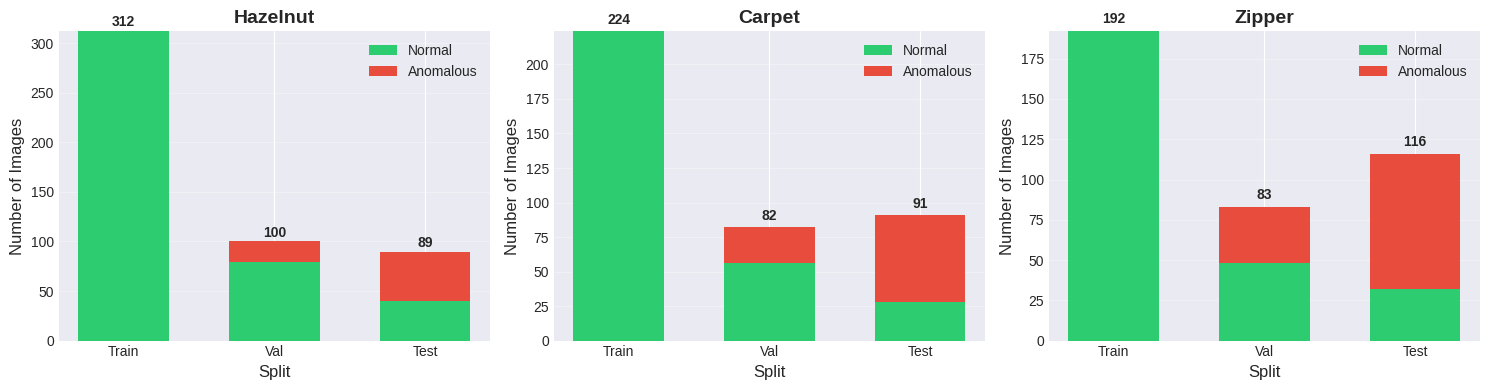

✓ Visualization saved


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, class_name in enumerate(CLASSES):
    ax = axes[idx]

    # Prepare data for stacked bar chart
    splits_names = ['Train', 'Val', 'Test']
    normal_counts = []
    anomalous_counts = []

    for split_name in ['train', 'val', 'test']:
        labels = splits[class_name][split_name]['labels']
        normal_counts.append(sum(1 for l in labels if l == 0))
        anomalous_counts.append(sum(1 for l in labels if l == 1))

    # Stacked bar chart
    x = np.arange(len(splits_names))
    width = 0.6

    ax.bar(x, normal_counts, width, label='Normal', color='#2ecc71')
    ax.bar(x, anomalous_counts, width, bottom=normal_counts,
           label='Anomalous', color='#e74c3c')

    ax.set_xlabel('Split', fontsize=12)
    ax.set_ylabel('Number of Images', fontsize=12)
    ax.set_title(f'{class_name.capitalize()}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(splits_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add count labels
    for i, (n, a) in enumerate(zip(normal_counts, anomalous_counts)):
        total = n + a
        ax.text(i, total + 5, str(total), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR.parent.parent / 'outputs' / 'visualizations' / 'split_distribution.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved")

## 5. Test Dataset Class with Transforms

In [9]:
# Get transforms
transform = get_clean_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

# Create dataset for hazelnut train split
test_dataset = MVTecDataset.from_split(
    splits['hazelnut']['train'],
    transform=transform,
    phase='train'
)

print(f"Dataset created: {len(test_dataset)} samples")
print(f"Stats: {test_dataset.get_stats()}")

# Test __getitem__
image, mask, label, path = test_dataset[0]
print(f"\nSample 0:")
print(f"  Image shape: {image.shape}")
print(f"  Image dtype: {image.dtype}")
print(f"  Image range: [{image.min():.3f}, {image.max():.3f}]")
print(f"  Mask: {mask}")
print(f"  Label: {label}")
print(f"  Path: {Path(path).name}")

print("\n✓ Dataset class works correctly!")

Dataset created: 312 samples
Stats: {'phase': 'train', 'total_samples': 312, 'normal_samples': 312, 'anomalous_samples': 0, 'anomaly_ratio': 0.0, 'masks_available': 0}

Sample 0:
  Image shape: torch.Size([3, 224, 224])
  Image dtype: torch.float32
  Image range: [-1.638, 1.358]
  Mask: None
  Label: 0
  Path: 344.png

✓ Dataset class works correctly!


## 6. Visualize Samples from Each Split

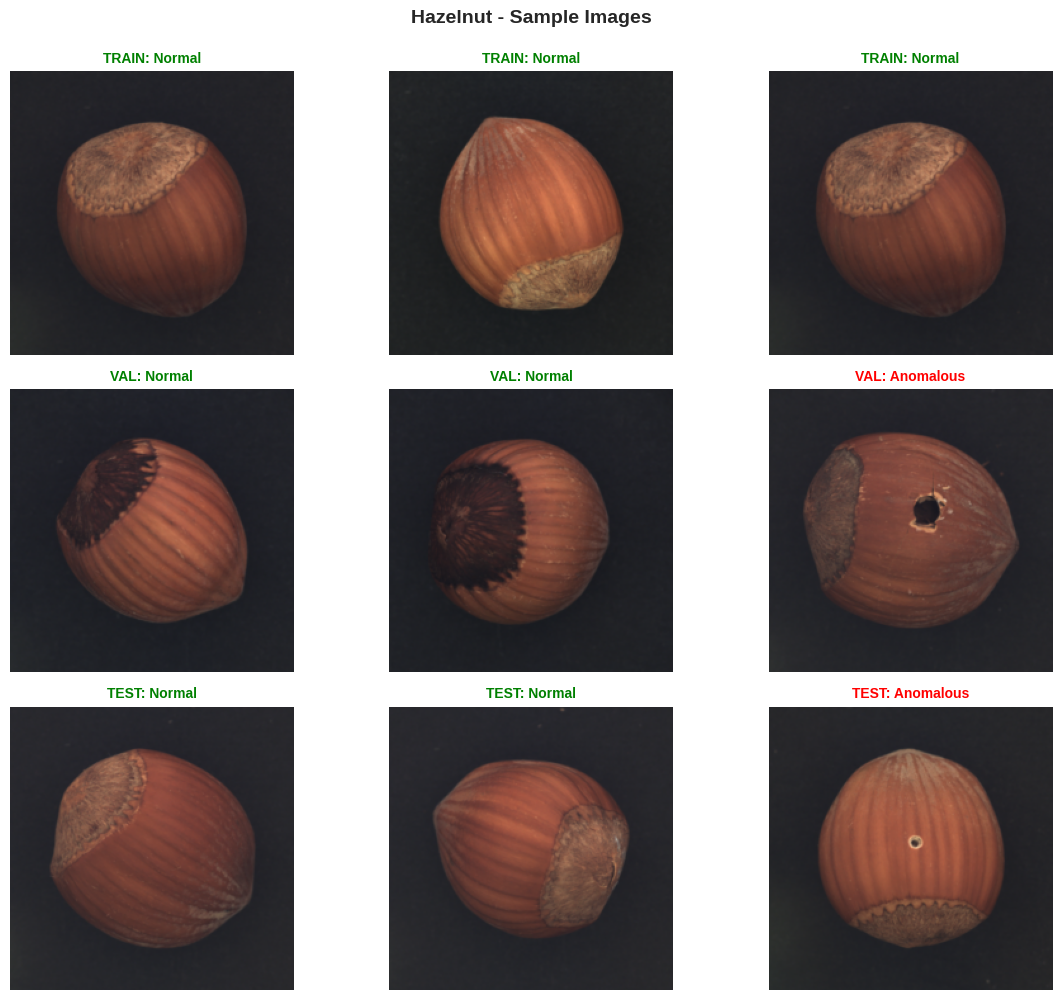

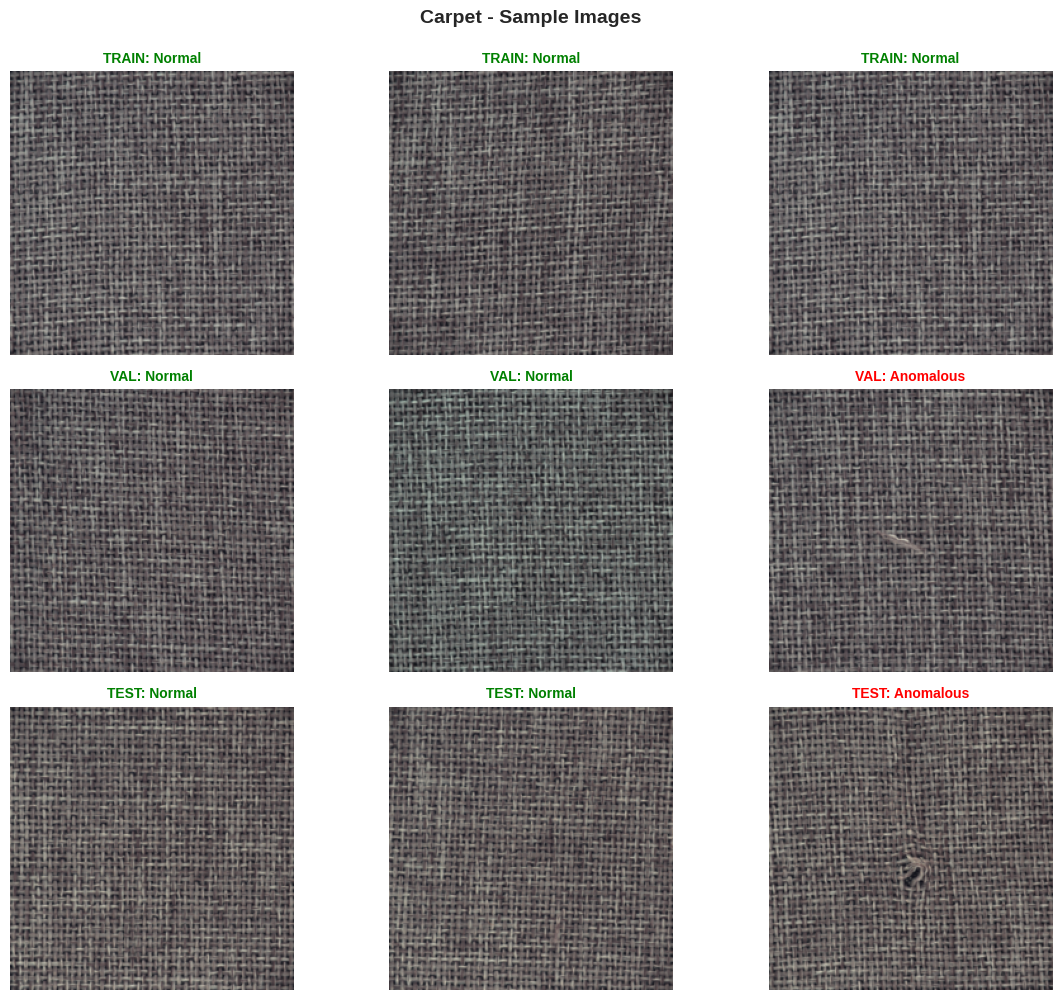

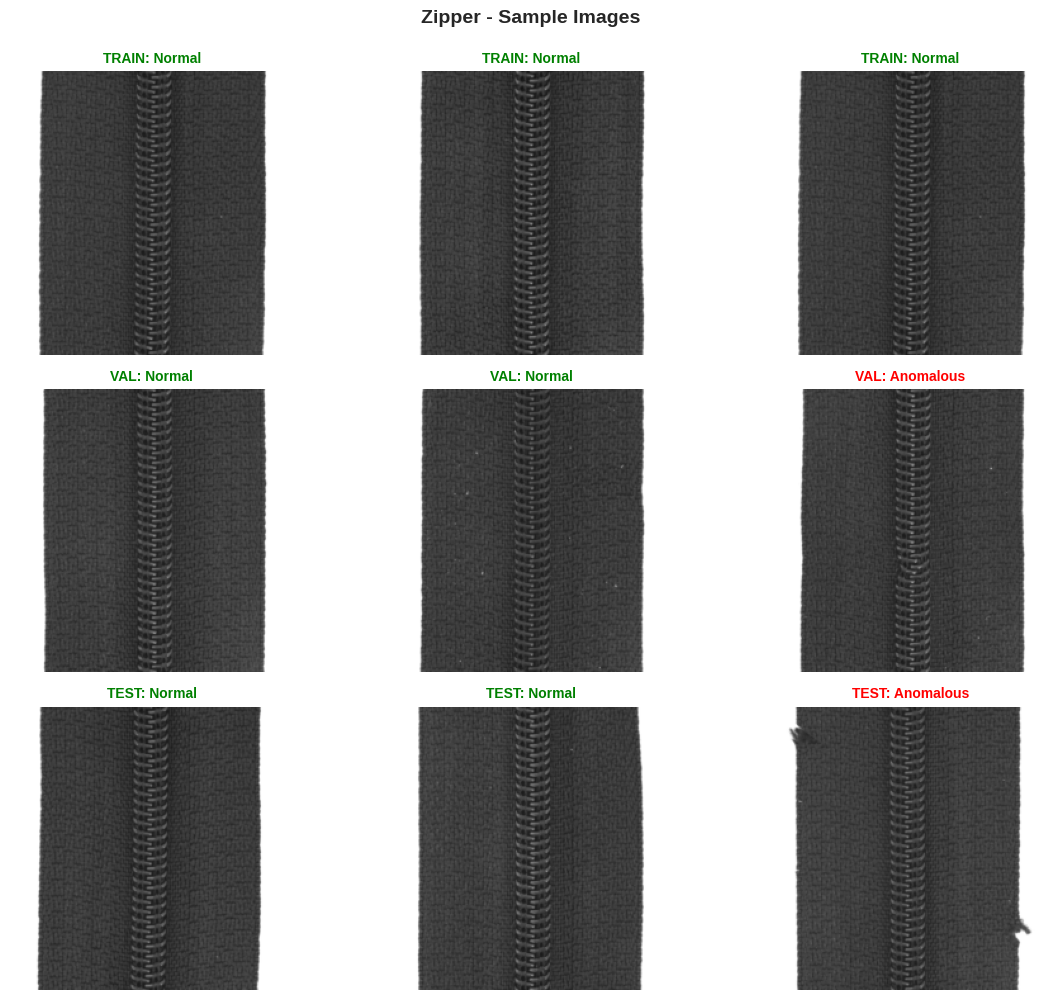

In [10]:
def denormalize(tensor, mean, std):
    """Denormalize image tensor for visualization."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_samples(class_name, splits, transform, num_samples=3):
    """Visualize samples from train/val/test splits."""
    fig, axes = plt.subplots(3, num_samples, figsize=(12, 10))

    split_names = ['train', 'val', 'test']

    for row_idx, split_name in enumerate(split_names):
        # Create dataset
        dataset = MVTecDataset.from_split(
            splits[class_name][split_name],
            transform=transform,
            phase=split_name
        )

        # Sample indices (try to get at least one anomalous if available)
        indices = []
        labels = splits[class_name][split_name]['labels']

        # Get normal samples
        normal_indices = [i for i, l in enumerate(labels) if l == 0]
        indices.extend(normal_indices[:num_samples-1] if normal_indices else [])

        # Try to get one anomalous sample
        anomalous_indices = [i for i, l in enumerate(labels) if l == 1]
        if anomalous_indices:
            indices.append(anomalous_indices[0])

        # Fill remaining if needed
        while len(indices) < num_samples:
            indices.append(indices[0] if indices else 0)

        indices = indices[:num_samples]

        for col_idx, idx in enumerate(indices):
            ax = axes[row_idx, col_idx]

            # Get sample
            image, mask, label, path = dataset[idx]

            # Denormalize for visualization
            image_vis = denormalize(
                image,
                config.dataset.normalize.mean,
                config.dataset.normalize.std
            )
            image_vis = image_vis.permute(1, 2, 0).numpy()
            image_vis = np.clip(image_vis, 0, 1)

            ax.imshow(image_vis)
            ax.axis('off')

            # Title
            label_str = 'Normal' if label == 0 else 'Anomalous'
            color = 'green' if label == 0 else 'red'
            ax.set_title(f"{split_name.upper()}: {label_str}",
                        fontsize=10, fontweight='bold', color=color)

    fig.suptitle(f'{class_name.capitalize()} - Sample Images',
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Visualize for each class
for class_name in CLASSES:
    visualize_samples(class_name, splits, transform, num_samples=3)
    print()

## 7. Save Splits to JSON

In [11]:
# Prepare metadata
metadata = {
    'created_at': datetime.now().isoformat(),
    'seed': config.seed,
    'train_ratio': config.split.train_ratio,
    'val_anomaly_ratio': config.split.val_anomaly_ratio,
    'classes': CLASSES,
    'dataset_path': str(DATASET_PATH),
    'image_size': config.dataset.image_size,
    'normalize_mean': config.dataset.normalize.mean,
    'normalize_std': config.dataset.normalize.std
}

# Save splits
output_path = OUTPUT_DIR / 'clean_splits.json'
save_splits(splits, output_path, metadata=metadata)

print(f"\n✓ Splits saved to: {output_path}")
print(f"  File size: {output_path.stat().st_size / 1024:.2f} KB")

Splits saved to /content/Detection-of-Anomalies-with-Localization/data/processed/clean_splits.json

✓ Splits saved to: /content/Detection-of-Anomalies-with-Localization/data/processed/clean_splits.json
  File size: 129.12 KB


## 8. Test Reproducibility

In [12]:
print("Testing reproducibility...\n")

# Create splits again with same seed
splits_test = create_clean_split(
    class_name='hazelnut',
    dataset_path=DATASET_PATH,
    train_ratio=config.split.train_ratio,
    val_anomaly_ratio=config.split.val_anomaly_ratio,
    seed=config.seed
)

# Compare with original
original = splits['hazelnut']

matches = {
    'train': original['train']['images'] == splits_test['train']['images'],
    'val': original['val']['images'] == splits_test['val']['images'],
    'test': original['test']['images'] == splits_test['test']['images']
}

print("Reproducibility check:")
for split_name, match in matches.items():
    status = "✓" if match else "✗"
    print(f"  {split_name}: {status}")

if all(matches.values()):
    print("\n✓ Splits are perfectly reproducible!")
else:
    print("\n✗ Warning: Splits are not reproducible!")

Testing reproducibility...

Reproducibility check:
  train: ✓
  val: ✓
  test: ✓

✓ Splits are perfectly reproducible!


## Summary

### ✅ Completed Tasks:

1. **Split Creation**: Created train/val/test splits for all 3 classes
2. **Integrity Verification**: Verified no overlap and file existence
3. **Statistics**: Calculated and displayed split statistics
4. **Visualization**: Visualized split distribution and sample images
5. **Dataset Class**: Tested MVTecDataset with transforms
6. **Persistence**: Saved splits to `clean_splits.json`
7. **Reproducibility**: Verified splits are reproducible with seed=42

### 📁 Output Files:

- `data/processed/clean_splits.json` - Split definitions for all classes
- `outputs/visualizations/split_distribution.png` - Split distribution chart

### 📊 Next Steps:

- **Step 2.1**: Implement domain shift transformations
- **Step 2.2**: Generate MVTec-Shift dataset
- **Step 3.1**: Implement PatchCore backbone